### Bank Reviews-Complaints Analysis

### The objective of the case study is to analyze customer review and predict customer satisfaction with the reviews
### 1)Data Processing
### 2)Key positive/Negative words(most frequent words)
### 3)Classification of reviews in positive,negative and neutral
### 4)Identify Key things of problems( using clustering , topic modelling)
### 5)Predicting star rating using reviews
### 6)Perform Intent Analysis

In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
#import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

from imblearn.over_sampling import RandomOverSampler

#FeatureEngineering
#!pip install lightgbm
#from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import  textblob
#import xgboost
#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers

from textblob import TextBlob
from nltk.stem import PorterStemmer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from textblob import Word

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline




[nltk_data] Error loading wordnet: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11004] getaddrinfo failed>


In [2]:
from imblearn.over_sampling import RandomOverSampler

In [3]:
df_reviews = pd.read_excel('F:\\analytix_labs\\5. Bank Reviews-Complaints Analysis\\BankReviews.xlsx')

In [4]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
Date        505 non-null datetime64[ns]
Stars       505 non-null int64
Reviews     505 non-null object
BankName    505 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


In [5]:
df_reviews.rename(columns={"stars":"Score","Reviews":"text"},inplace = True)

In [6]:
df=df_reviews

In [11]:
df['text'] = df['text'].astype(str)
df['count_sent']=df["text"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
df['count_word']=df["text"].apply(lambda x: len(str(x).split()))

#Unique word count
df['count_unique_word']=df["text"].apply(lambda x: len(set(str(x).split())))

#Letter count
df['count_letters']=df["text"].apply(lambda x: len(str(x)))

#Word density

df['word_density'] = df['count_letters'] / (df['count_word']+1)

#punctuation count
df["count_punctuations"] =df["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df["count_words_upper"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#upper case words count
df["count_words_lower"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))

#title case words count
df["count_words_title"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df["count_stopwords"] = df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#Average length of the words
df["mean_word_len"] = df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Number of numeric
df['numeric'] = df['text'].apply(lambda x :len([x for x in x.split() if x.isdigit()]))

#Number of alphanumeric
df['alphanumeric'] = df['text'].apply(lambda x :len([x for x in x.split() if x.isalnum()]))

#Number of alphabetics
df['alphabetetics'] = df['text'].apply(lambda x :len([x for x in x.split() if x.isalpha()]))

#Number of alphabetics
df['Spaces'] = df['text'].apply(lambda x :len([x for x in x.split() if x.isspace()]))

#Number of Words ends with
df['words_ends_with_et'] = df['text'].apply(lambda x :len([x for x in x.lower().split() if x.endswith('et')]))

#Number of Words ends with
df['words_start_with_no'] = df['text'].apply(lambda x :len([x for x in x.lower().split() if x.startswith('no')]))

# Count the occurences of all words
df['wordcounts'] = df['text'].apply(lambda x :dict([ [t, x.split().count(t)] for t in set(x.split()) ]))

pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

df['noun_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'noun'))
df['verb_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'verb'))
df['adj_count']  = df['text'].apply(lambda x: check_pos_tag(x, 'adj'))
df['adv_count']  = df['text'].apply(lambda x: check_pos_tag(x, 'adv'))
df['pron_count'] = df['text'].apply(lambda x: check_pos_tag(x, 'pron')) 


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk



**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\share\\nltk_data'
    - 'C:\\ProgramData\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


**********************************************************************
  Resource averaged_perceptron_tagger not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.

In [19]:
df

,Date,Stars,text,BankName,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuations,...,alphabetetics,Spaces,words_ends_with_et,words_start_with_no,wordcounts,noun_count,verb_count,adj_count,adv_count,pron_count
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,1,19,19,126,6.300000,4,...,15,0,0,0,"{'move': 1, 'professional': 1, 'job,': 1, 'our...",0,0,0,0,0
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,1,25,23,159,6.115385,4,...,21,0,0,0,"{'you': 1, 'professional': 1, 'our': 1, 'for':...",0,0,0,0,0
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,1,79,64,462,5.775000,8,...,73,0,0,1,"{'but': 1, 'on': 1, 'Brad': 1, 'needs.': 1, 'n...",0,0,0,0,0
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,1,108,78,605,5.550459,9,...,101,0,0,1,"{'Brad': 4, 'time': 1, 'entire': 1, 'out': 1, ...",0,0,0,0,0
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,1,59,47,341,5.683333,6,...,53,0,0,1,"{'working': 1, 'purchase!': 1, 'professional':...",0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,2016-02-06,1,\r\nI never write reviews but had to this time...,North American Savings Bank,3,455,233,2458,5.390351,38,...,420,0,0,6,"{'told': 3, 'messages': 1, 'time': 3, 'time,':...",0,0,0,0,0
501,2016-07-25,1,\r\nIt all started when Bob G ran a credit che...,North American Savings Bank,3,164,109,828,5.018182,23,...,143,0,1,2,"{'ID': 2, 'told': 2, 'years': 1, 'Power': 1, '...",0,0,0,0,0
502,2017-09-27,1,\r\nWhat a horrible experience. We have excell...,North American Savings Bank,3,135,109,752,5.529412,19,...,117,0,1,2,"{'Thankfully,': 1, 'want': 1, 'contacted': 1, ...",0,0,0,0,0
503,2017-12-24,1,"\r\nRep was extremely professional, friendly, ...",North American Savings Bank,3,211,147,1100,5.188679,34,...,182,0,1,0,"{'told': 1, 'his': 1, 'want': 1, 'Over': 1, 'e...",0,0,0,0,0


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
Date        505 non-null datetime64[ns]
Stars       505 non-null int64
text        505 non-null object
BankName    505 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


In [6]:
 df_reviews['text'] =df_reviews["text"].apply(lambda x: x.lower() )

In [7]:
df_reviews['text'] =df_reviews["text"].apply(lambda x: re.sub("([^0-9A-Za-z \t])", "", x) )

In [8]:
df_reviews['polarity'] = df_reviews["text"].apply(lambda x: TextBlob(x).sentiment.polarity )

In [9]:
df_reviews.Stars.value_counts()

5    410
1     95
Name: Stars, dtype: int64

In [10]:
df_reviews

,Date,Stars,text,BankName,polarity
0,2017-04-10,5,great job wyndham capital each person was prof...,Wyndham Capital Mortgage,0.433333
1,2017-02-10,5,matthew richardson is professional and helpful...,Wyndham Capital Mortgage,0.453333
2,2017-08-21,5,we had a past experience with wyndham mortgage...,Wyndham Capital Mortgage,-0.030106
3,2017-12-17,5,we have been dealing with brad thomka from the...,Wyndham Capital Mortgage,0.067698
4,2016-05-27,5,i cant express how grateful i am for the suppo...,Wyndham Capital Mortgage,0.115000
...,...,...,...,...,...
500,2016-02-06,1,i never write reviews but had to this time to ...,North American Savings Bank,0.103432
501,2016-07-25,1,it all started when bob g ran a credit check w...,North American Savings Bank,0.139815
502,2017-09-27,1,what a horrible experience we have excellent c...,North American Savings Bank,0.074444
503,2017-12-24,1,rep was extremely professional friendly and he...,North American Savings Bank,0.176042


### Classification of reviews in positive,negative and neutral

In [11]:
df_reviews['sentiment']=np.where(df_reviews['polarity'] >= 0.34 , 'Positive',np.where(df_reviews['polarity'] < 0.2 , 'Negative','Nuetral'))

In [12]:
df_reviews.loc[(df_reviews['sentiment']== 'Negative') & (df_reviews['Stars']== 5),:]

,Date,Stars,text,BankName,polarity,sentiment
2,2017-08-21,5,we had a past experience with wyndham mortgage...,Wyndham Capital Mortgage,-0.030106,Negative
3,2017-12-17,5,we have been dealing with brad thomka from the...,Wyndham Capital Mortgage,0.067698,Negative
4,2016-05-27,5,i cant express how grateful i am for the suppo...,Wyndham Capital Mortgage,0.115000,Negative
11,2016-02-06,5,usten butler brought the humanity and connecti...,Wyndham Capital Mortgage,0.196639,Negative
13,2017-03-04,5,if i had a million friends i would recommend a...,Wyndham Capital Mortgage,0.177500,Negative
...,...,...,...,...,...,...
466,2016-09-30,5,alex was extremely helpful and always availabl...,North American Savings Bank,0.194048,Negative
472,2016-03-29,5,i worked with a person name andrew leehy he i...,North American Savings Bank,0.110417,Negative
476,2016-10-29,5,i was hesitant to use a nonlocal mortgage comp...,North American Savings Bank,0.020833,Negative
477,2016-12-05,5,i was hesitant to use a nonlocal mortgage comp...,North American Savings Bank,0.020833,Negative


### Split Data into test and train

In [13]:
# create a new DataFrame that only contains the 5-star and 1-star reviews

# define X and y
X = df_reviews.text
y = df_reviews.Stars

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(378,)
(127,)
(378,)
(127,)


In [14]:
#Abbrevations and Words correction
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)
    return(text)

In [15]:
stop = set(nltk.corpus.stopwords.words('english'))
# initialize stemmer
stemmer = nltk.stem.snowball.SnowballStemmer('english')

In [16]:
import string
def pre_process(text):
    #text = text.str.replace('/','')                           #Replacing the / with none
    #text = text.apply(lambda x: re.sub("  "," ", x))          #Replacing double space with single space
    #text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,']", "", text)      #Replacing special character with none
    #text = re.sub(r'[0-9]+', '', text)                        #Replacing numbers with none
    #text = text.apply(lambda x: " ".join(x.translate(str.maketrans('', '', string.punctuation)) for x in x.split() if x.isalpha()))
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #Removing stop words
    text = text.apply(lambda x: str(TextBlob(x).correct()))                      #Correct spelling corrections
    #text = text.apply(lambda x: " ".join(PorterStemmer().stem(word) for word in x.split())) #Stemming using porter stemmer
    text = text.apply(lambda x: " ".join(stemmer.stem(word) for word in x.split()))        #Stemming
    #text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))   #lemmatization
    #text = text.apply(lambda x: " ".join(word for word, pos in pos_tag(x.split()) if pos not in ['NN','NNS','NNP','NNPS'])) #Removing nouns etc
    return(text)

In [17]:
X_train = X_train.apply(lambda x: clean_text(x))
X_test = X_test.apply(lambda x: clean_text(x))

In [18]:
X_train=pre_process(X_train)
X_test=pre_process(X_test)

In [19]:
X_train

501    start bob g ran credit check without knowledg ...
172    great webster knowledg respons alway got back ...
80     pleasur work robert first call kept well infor...
46     start bob g ran credit check without knowledg ...
318    agre star review easi clear work hello knowled...
                             ...                        
255    viness word fantasticsh everi step way perfect...
72     fast easi leav comfort home seven that friend ...
396    friend mine told financ hous unbeliev interest...
235    work on garrett process financ loan quick issu...
37     peter team great work profession prompt respon...
Name: text, Length: 378, dtype: object

In [63]:
y_test

307    5
343    5
47     1
67     5
361    5
      ..
41     1
360    5
289    5
497    1
293    5
Name: Stars, Length: 127, dtype: int64

In [20]:
# get the tf-idf table 

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 0.05, max_df=0.95,
                             ngram_range=(1, 1), 
                             stop_words='english')
X_train_tfidf=vectorizer.fit_transform(X_train)

In [21]:
X_train_tfidf

<378x122 sparse matrix of type '<class 'numpy.float64'>'
	with 5237 stored elements in Compressed Sparse Row format>

In [22]:
dtm1=pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names())

In [23]:
dtm1

,abl,adam,alway,anoth,answer,anyon,ask,avail,bank,begin,...,time,told,took,use,want,way,week,went,work,year
0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.170380,0.0,0.186148,0.0,...,0.000000,0.332143,0.162108,0.301612,0.000000,0.000000,0.159632,0.000000,0.000000,0.17038
1,0.0,0.0,0.323934,0.0,0.310073,0.00000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157285,0.00000
3,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.171230,0.0,0.187077,0.0,...,0.000000,0.333800,0.162917,0.303117,0.000000,0.000000,0.160429,0.000000,0.000000,0.17123
4,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.308275,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.481098,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,0.0,0.0,0.420145,0.0,0.201083,0.00000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.242648,0.000000,0.000000,0.000000,0.00000
374,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
375,0.0,0.0,0.000000,0.0,0.108769,0.11438,0.000000,0.0,0.000000,0.0,...,0.079739,0.126799,0.000000,0.000000,0.245632,0.000000,0.000000,0.115144,0.067673,0.00000
376,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.258332,0.151828,0.00000


In [24]:
X_test_tfidf = vectorizer.transform(X_test)

In [25]:
X_test_tfidf

<127x122 sparse matrix of type '<class 'numpy.float64'>'
	with 1780 stored elements in Compressed Sparse Row format>

### 5)Predicting star rating using reviews

In [26]:
#!pip install imblearn
ros = RandomOverSampler(random_state=123)

X_train_tfidf_os, y_train_tfidf_os = ros.fit_sample(X_train_tfidf, y_train)

unique_elements, counts_elements = np.unique(y_train_tfidf_os, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[  1   5]
 [308 308]]


In [27]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,  valid_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(classifier.predict(feature_vector_train), label), metrics.accuracy_score(predictions, valid_y)

In [28]:
#Naive Bayes
# Naive Bayes on TF-IDF
accuracy_L1 = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_os, y_train_tfidf_os, X_test_tfidf, y_test)
print("NB  for L1, Count Vectors: ", accuracy_L1)

#Linear SVC
# Linear SVC on Count Vectors and TF-IDF
accuracy_L1 = train_model(SVC(), X_train_tfidf_os, y_train_tfidf_os, X_test_tfidf, y_test)
print("SVC  for L1, Count Vectors: ", accuracy_L1)

#Logistic Regression
# Logistic Regression on Count Vectors and TF-IDF
accuracy_L1 = train_model(LogisticRegression(), X_train_tfidf_os, y_train_tfidf_os, X_test_tfidf, y_test)
print("LR  for L1, Count Vectors: ", accuracy_L1)

NB  for L1, Count Vectors:  (0.9334415584415584, 0.9133858267716536)
SVC  for L1, Count Vectors:  (0.9983766233766234, 0.905511811023622)
LR  for L1, Count Vectors:  (0.9448051948051948, 0.937007874015748)


### Identify Key things of problems( using clustering , topic modelling)

In [29]:
# get the tf-idf table 

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 0.05, max_df=0.95,
                             ngram_range=(1, 1), 
                             stop_words='english')
vectorizer.fit(df_reviews['text'])

TfidfVectorizer(max_df=0.95, min_df=0.05, stop_words='english')

In [30]:
# Create a training data
X_train = vectorizer.transform(df_reviews['text'])

In [31]:
X_train

<505x104 sparse matrix of type '<class 'numpy.float64'>'
	with 5472 stored elements in Compressed Sparse Row format>

In [32]:
# train a LDA Model

from sklearn import decomposition

lda_model = decomposition.LatentDirichletAllocation(n_components=8, learning_method='online', max_iter=50)
X_topics = lda_model.fit_transform(X_train)
topic_word = lda_model.components_ 
vocab = vectorizer.get_feature_names()

In [33]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

topic_summaries

['responsive lender did phone patient work good got best questions',
 'friendly said kept great business things pleasure helpful just help',
 'working pleasure experience beginning definitely thank mortgage able best recommend',
 'home process easy loan great helped recommend team service time',
 'rate loan called did hard read email good refinance told',
 'closing make went read loan company took home weeks sure',
 'professional team great quick recommend work time questions answered closed',
 'process extremely service helpful knowledgeable loan mortgage entire great customer']

In [34]:
#Apply TfidfVectorizer to review text
from sklearn.cluster import KMeans
from sklearn import metrics

In [35]:
# calculate SC for K=3 through K=12
k_range = range(2, 20)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(X_train)
    scores.append(metrics.silhouette_score(X_train, km.labels_))

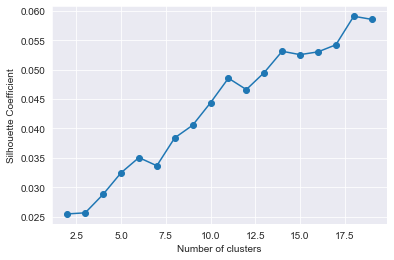

In [36]:
# plot the results
plt.plot(k_range, scores,'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [37]:
cluster_range = range( 2, 20 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( X_train )
    cluster_errors.append( clusters.inertia_ )

In [38]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

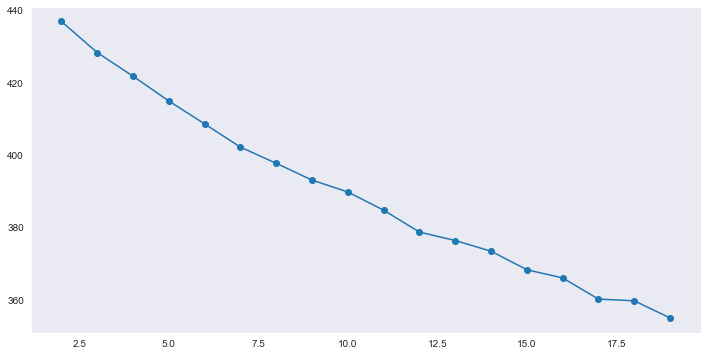

In [39]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [40]:
km_4=KMeans(n_clusters=4,random_state=123).fit(X_train)
km_5=KMeans(n_clusters=5,random_state=123).fit(X_train)
km_6=KMeans(n_clusters=6,random_state=123).fit(X_train)
km_7=KMeans(n_clusters=7,random_state=123).fit(X_train)
km_8=KMeans(n_clusters=8,random_state=123).fit(X_train)
km_9=KMeans(n_clusters=9,random_state=123).fit(X_train)

In [170]:
pd.Series(km_4.labels_).value_counts()/sum(pd.Series(km_4.labels_).value_counts())

2    0.312871
3    0.287129
1    0.211881
0    0.188119
dtype: float64

In [171]:
pd.Series(km_5.labels_).value_counts()/sum(pd.Series(km_5.labels_).value_counts())

0    0.235644
1    0.217822
3    0.186139
2    0.182178
4    0.178218
dtype: float64

In [172]:
pd.Series(km_6.labels_).value_counts()/sum(pd.Series(km_6.labels_).value_counts())

2    0.245545
3    0.196040
4    0.192079
0    0.166337
1    0.108911
5    0.091089
dtype: float64

In [41]:
pd.Series(km_7.labels_).value_counts()/sum(pd.Series(km_7.labels_).value_counts())

6    0.209901
2    0.192079
4    0.146535
3    0.146535
0    0.116832
1    0.099010
5    0.089109
dtype: float64

In [174]:
pd.Series(km_8.labels_).value_counts()/sum(pd.Series(km_8.labels_).value_counts())

6    0.160396
4    0.146535
7    0.142574
2    0.140594
1    0.122772
3    0.120792
0    0.106931
5    0.059406
dtype: float64

In [176]:
pd.Series(km_9.labels_).value_counts()/sum(pd.Series(km_9.labels_).value_counts())

4    0.146535
6    0.140594
2    0.132673
7    0.130693
3    0.118812
0    0.108911
1    0.091089
8    0.077228
5    0.053465
dtype: float64

In [42]:
# we create a kmeans model
model = KMeans(n_clusters=7, 
               init='k-means++', 
               max_iter=100, n_init=1,random_state=5)

In [43]:
# apply the model on this prepared data
res = model.fit(X_train)
res

KMeans(max_iter=100, n_clusters=7, n_init=1, random_state=5)

In [44]:
cluster_centers = np.array(res.cluster_centers_)

In [45]:
# sorting the cluster centers
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]

In [46]:
# Getting the vocalbulary as well as cluster centers
# Firstly, set of words from the tf-idf itself
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab)

In [47]:
# get top 10 words from that cluster
words=set()
for i in range(len(res.cluster_centers_)):
    words = set(vocab[sorted_vals[i][-10:]])
    print(words)

{'friendly', 'know', 'able', 'helpful', 'end', 'rate', 'didnt', 'read', 'loan', 'getting'}
{'process', 'mortgage', 'home', 'close', 'experience', 'recommend', 'provided', 'lending', 'loan', 'team'}
{'great', 'hard', 'best', 'service', 'work', 'customer', 'responsive', 'experience', 'helpful', 'worked'}
{'mortgage', 'company', 'best', 'step', 'way', 'time', 'make', 'officer', 'read', 'loan'}
{'great', 'home', 'process', 'easy', 'work', 'time', 'responsive', 'recommend', 'questions', 'highly'}
{'credit', 'said', 'time', 'told', 'day', 'rate', 'weeks', 'closing', 'nasb', 'loan'}
{'lender', 'professional', 'thank', 'pleasure', 'did', 'excellent', 'working', 'phone', 'loan', 'called'}


In [48]:
# how many observations are in each cluster

model.labels_

array([6, 6, 1, 1, 1, 4, 3, 3, 6, 4, 4, 3, 2, 2, 6, 3, 5, 1, 5, 5, 5, 5,
       1, 3, 3, 1, 6, 5, 4, 4, 3, 3, 3, 4, 4, 1, 0, 4, 4, 5, 1, 3, 6, 5,
       6, 3, 5, 5, 0, 5, 3, 4, 6, 1, 1, 4, 5, 1, 4, 5, 4, 0, 3, 6, 3, 6,
       6, 3, 0, 4, 4, 0, 3, 6, 3, 6, 6, 3, 0, 4, 6, 5, 4, 1, 3, 5, 4, 5,
       4, 4, 5, 3, 6, 3, 6, 6, 3, 5, 5, 0, 5, 1, 3, 5, 5, 5, 5, 0, 0, 0,
       6, 6, 6, 4, 0, 3, 1, 3, 3, 4, 2, 2, 2, 6, 6, 4, 4, 1, 2, 3, 3, 4,
       4, 4, 3, 3, 2, 2, 6, 4, 4, 3, 3, 1, 0, 6, 4, 4, 6, 4, 3, 2, 6, 5,
       5, 6, 3, 5, 3, 1, 3, 3, 1, 6, 5, 4, 4, 3, 3, 3, 3, 4, 4, 1, 0, 4,
       4, 6, 5, 4, 3, 4, 1, 2, 6, 5, 4, 3, 3, 3, 5, 0, 2, 0, 3, 1, 1, 5,
       2, 3, 2, 3, 4, 3, 3, 2, 6, 4, 4, 2, 2, 4, 2, 2, 3, 3, 5, 6, 4, 5,
       1, 3, 3, 6, 5, 5, 1, 6, 3, 5, 5, 0, 5, 5, 5, 4, 5, 5, 3, 5, 2, 2,
       6, 3, 2, 4, 4, 4, 4, 3, 5, 4, 4, 4, 1, 3, 5, 1, 2, 4, 3, 4, 6, 2,
       2, 2, 4, 2, 1, 4, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 6, 6, 1,
       5, 5, 2, 4, 3, 2, 4, 4, 4, 4, 4, 0, 0, 1, 4,

In [49]:
# how many observations are in each cluster

df_reviews['cluster'] = model.labels_


In [50]:
df_reviews.groupby('cluster').count()

,Date,Stars,text,BankName,polarity,sentiment
cluster,,,,,,
0,35,35,35,35,35,35
1,71,71,71,71,71,71
2,55,55,55,55,55,55
3,104,104,104,104,104,104
4,110,110,110,110,110,110
5,71,71,71,71,71,71
6,59,59,59,59,59,59


In [51]:
# what does each cluster look like
df_reviews.groupby('cluster').mean()

,Stars,polarity
cluster,,
0,4.085714,0.250113
1,4.492958,0.239485
2,5.000000,0.418222
3,4.269231,0.227832
4,4.963636,0.306260
5,2.633803,0.135042
6,3.915254,0.210204
